In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import geopandas
import osmnx as ox
import networkx as nx
#import geonetworkx as gnx
#from shapely.geometry import Point, LineString

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.0'

In [3]:
osm_berlin = ox.graph_from_place("Berlin, Deutschland", network_type = "drive", simplify = True)
gdf_nodes_berlin, gdf_edges_berlin = ox.graph_to_gdfs(osm_berlin)

#gdf_nodes_berlin = gdf_nodes_berlin.rename(columns = {'y':'latitude', 'x':'longitude'})

print('Nodes in Berlin:')
display(gdf_nodes_berlin.head())
print('-'*50)
print('Edges in Berlin:')
display(gdf_edges_berlin.head())

Nodes in Berlin:


,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172539,52.565205,13.335501,3,NaN,NaN,POINT (13.33550 52.56521)
172545,52.567033,13.346605,4,NaN,NaN,POINT (13.34661 52.56703)
172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)
172547,52.564077,13.339564,3,NaN,NaN,POINT (13.33956 52.56408)
172549,52.563398,13.342901,3,NaN,NaN,POINT (13.34290 52.56340)


--------------------------------------------------
Edges in Berlin:


osmid             name  \
u      v         key                                                   
172539 34694265  0                          4610047  Holländerstraße   
       34694336  0                          5117633   Gotthardstraße   
       172562    0    [31740296, 33231778, 4804202]   Gotthardstraße   
172545 271370539 0                         24973218      Teichstraße   
       28345515  0                          4546470      Teichstraße   

                        highway maxspeed  oneway   length  \
u      v         key                                        
172539 34694265  0     tertiary       50   False  237.653   
       34694336  0    secondary       50   False  687.484   
       172562    0    secondary       50   False  436.809   
172545 271370539 0     tertiary       50   False   17.179   
       28345515  0     tertiary       50   False  171.849   

                                                               geometry lanes  \
u      v         key                                                            
172539 34694265  0    LINESTRING (13.33550 52.56521, 13.33560 52.565...   NaN   
       34694336  0    LINESTRING (13.33550 52.56521, 13.33565 52.565...   NaN   
       172562    0    LINESTRING (13.33550 52.56521, 13.33533 52.565...     2   
172545 271370539 0    LINESTRING (13.34661 52.56703, 13.34664 52.56688)   NaN   
       28345515  0    LINESTRING (13.34661 52.56703, 13.34659 52.567...   NaN   

                      ref bridge tunnel junction width access service area  \
u      v         key                                                         
172539 34694265  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       34694336  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       172562    0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
172545 271370539 0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       28345515  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   

                     est_width  
u      v         key            
172539 34694265  0         NaN  
       34694336  0         NaN  
       172562    0         NaN  
172545 271370539 0         NaN  
       28345515  0         NaN

In [4]:
# Checks
print('Type of graph that we get from osmnx:', type(osm_berlin))
print('Type of the nodes/edges storage:', type(gdf_nodes_berlin))
print('Shape of nodes:', gdf_nodes_berlin.shape)
print('Shape of edges:', gdf_edges_berlin.shape)

Type of graph that we get from osmnx: <class 'networkx.classes.multidigraph.MultiDiGraph'>
Type of the nodes/edges storage: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape of nodes: (27956, 6)
Shape of edges: (72908, 17)


We have the preliminary info, now let's check for missing values and visualize the graph.

In [5]:
print('Null values for nodes:')
print(gdf_nodes_berlin.isnull().sum())
print()
print('Null values for edges:')
print(gdf_edges_berlin.isnull().sum())

Null values for nodes:
y                   0
x                   0
street_count        0
ref             27867
highway         26712
geometry            0
dtype: int64

Null values for edges:
osmid            0
name          1255
highway          0
maxspeed      7151
oneway           0
length           0
geometry         0
lanes        52499
ref          70962
bridge       71971
tunnel       72624
junction     72757
width        70585
access       72118
service      72905
area         72901
est_width    72902
dtype: int64


This check below is needed since it is important to know what **'highway'** represents for nodes. Luckily, it is something that we would expect, the values below mostly exist where roads intersect. Also, since a node can represent an intersection which is not particularly important(like a point where two small streets cross each other), we can understand such a high number of NaNs under the node highway column.

By the way, the **'ref'** column stands for the reference page of a location in openstreetmap wiki, so we don't need to worry about it having too many empty cells, since only landmarks will have a wiki page dedicated for them.

In [6]:
gdf_nodes_berlin['highway'].value_counts()

turning_circle       916
traffic_signals      180
motorway_junction     97
crossing              35
turning_loop          13
mini_roundabout        3
Name: highway, dtype: int64

The edges also look fine, only around 10% of them have missing max speed values.

Let's visualize the road network of Berlin now.

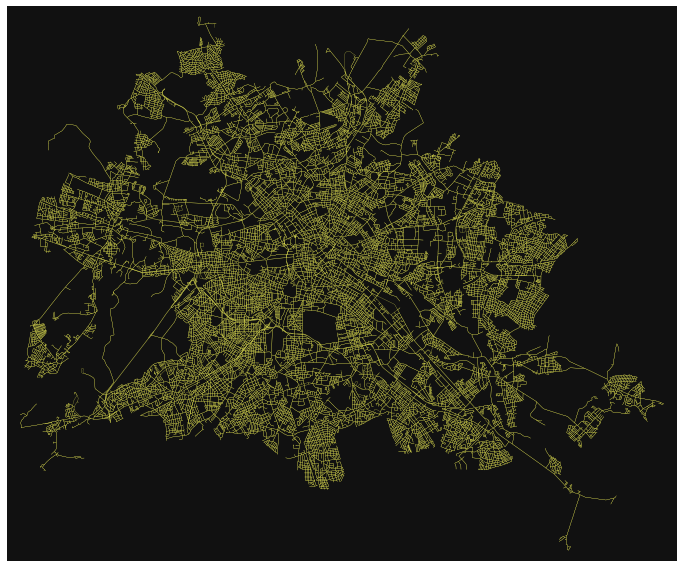

In [7]:
fig, ax = ox.plot_graph(osm_berlin, figsize=(12, 12), node_color = 'r', node_size = 0, edge_linewidth = 0.2, edge_color = '#FFFF5C')

The figure above seems to represent Berlin correctly(or at least the central part), but it has a huge size that makes it hard for us to have a rough interpretation. Let's focus on its 'Mitte' district only.

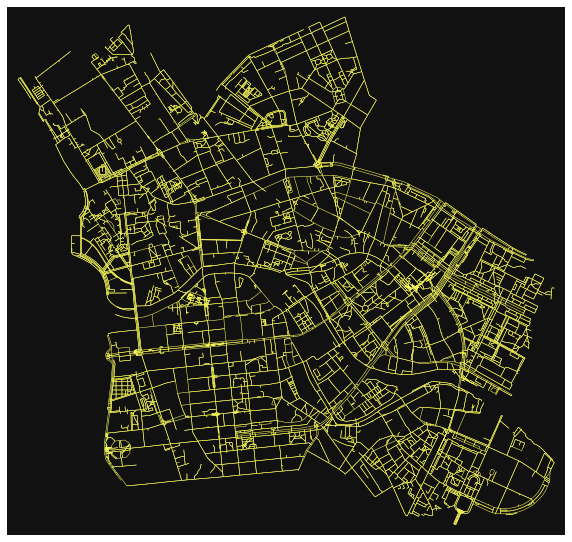

In [8]:
mitte = ox.graph_from_place("Mitte, Berlin, Germany", network_type = "all", simplify = True)

fig, ax = ox.plot_graph(mitte, figsize=(10, 10), node_color = 'r', node_size = 0, edge_linewidth = 0.5, edge_color = '#FFFF5C')

As one would expect, we see that River Spree splits the city in half in the south. Also, as with most European cities, the networks in the city are quite complex that there is no clear design pattern, which can be found in most American city centres.

The visual above can be further enriched with adding buildings and other landmarks, but because of resource constraints we decide not to show them for now.

### Loading Uber Movement Data

The graph we get from OpenStreetMap has a variety of nice attributes for edges, with 'maxspeed' attribute being the most important. Yet this feature does not represent the actual speeds in roads, it is just the allowed maximum speed a car can have when the traffic is in free-flow mode.

We can get a better estimation of road speeds by enriching our data with the movement dataset provided by Uber, which comes with several statistics regarding road speed. Let's take a look before cleaning& merging.

In [9]:
u_berlin = pd.read_csv('berlin.csv')
u_berlin.head()

,year,quarter,hour_of_day,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev,speed_kph_p50,speed_kph_p85
0,2020,1,14,26f5e6a3e3fe82a35c5bc2b9fa1e8e91430e38c0,4c3af007468dbe535a5c1c4f646d3f596e703283,0b2ff487a279b754e694950fdaa2a94e397a9746,229745434,2383000683,2383000685,40.058,9.652,37.800,49.316
1,2020,1,20,26f5e6a3e3fe82a35c5bc2b9fa1e8e91430e38c0,4c3af007468dbe535a5c1c4f646d3f596e703283,0b2ff487a279b754e694950fdaa2a94e397a9746,229745434,2383000683,2383000685,41.899,9.381,40.290,48.619
2,2020,1,23,26f5e6a3e3fe82a35c5bc2b9fa1e8e91430e38c0,4c3af007468dbe535a5c1c4f646d3f596e703283,0b2ff487a279b754e694950fdaa2a94e397a9746,229745434,2383000683,2383000685,46.349,11.172,44.781,56.045
3,2020,1,0,26f5e6a3e3fe82a35c5bc2b9fa1e8e91430e38c0,4c3af007468dbe535a5c1c4f646d3f596e703283,0b2ff487a279b754e694950fdaa2a94e397a9746,229745434,2383000683,2383000685,49.835,8.916,50.585,57.449
4,2020,1,2,277640ca389fc7f0fc8a583386e6063df80485f0,ad26106a25d52c3409bd0165f05de3047a4e96b5,9c00a9375aeaba9c08f4f2fd507cc1808ba83b89,9932085,81398215,1236497752,41.196,5.523,40.906,45.487


We have downloaded the dataset that includes speed data of drivable Berlin roads from the first quarter of 2020(that is, between January and April) on an hourly basis. Hour of day column is designed with respect to the 24h system, so 14 is equal to the timeframe between 2 and 3 pm. 

Some columns like segment_id, start_junction_id are deprecated and we don't need them anyway for merging.

We will only keep the osm id's of roads, and the mean & std values of road speeds. Their units are in kilometres per hour, the same as that of 'maxspeed' column existing in our graph.

Lastly, we will only analyze the traffic situation in the morning, between 7 and 10 am.

In [10]:
u_berlin = u_berlin[(u_berlin['hour_of_day'] >= 7) & (u_berlin['hour_of_day'] < 10)]
u_berlin = u_berlin[['hour_of_day', 'osm_way_id', 'osm_start_node_id', 'osm_end_node_id', 'speed_kph_mean', 'speed_kph_stddev']]
u_berlin.head()

,hour_of_day,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
13,8,9932085,81398215,1236497752,36.605,8.107
20,9,9932085,81398215,1236497752,36.319,9.573
26,7,9932085,81398215,1236497752,35.446,5.083
35,8,9932085,1236497729,1236497752,28.831,13.103
36,9,9932085,1236497729,1236497752,31.308,11.265


In [11]:
print('Shape of Uber data after filtering:', u_berlin.shape)
print('Number of unique edge(road) ids:', u_berlin['osm_way_id'].nunique())

Shape of Uber data after filtering: (79639, 6)
Number of unique edge(road) ids: 13776


In [12]:
# Checking for nulls
print(u_berlin.isnull().sum())

hour_of_day          0
osm_way_id           0
osm_start_node_id    0
osm_end_node_id      0
speed_kph_mean       0
speed_kph_stddev     0
dtype: int64


In [13]:
# Checking if there are any illogical speed values
u_berlin[['speed_kph_mean', 'speed_kph_stddev']].describe()

# Looks like the mean & std values make sense.

,speed_kph_mean,speed_kph_stddev
count,79639.000000,79639.000000
mean,37.429043,10.215350
std,12.325510,3.739455
min,5.173000,2.229000
25%,29.592500,7.485000
50%,37.252000,9.301000
75%,44.479000,12.313500
max,115.181000,42.290000


We can add the edge speeds now.

In [14]:
# Mapping the column names so that we can merge the two dataframes later.
u_berlin = u_berlin.rename(columns = {'osm_way_id':'osmid', 'osm_start_node_id':'u', 'osm_end_node_id':'v'})

In [15]:
berlin_edges = gdf_edges_berlin.copy()
berlin_edges = berlin_edges.explode('osmid')
berlin_edges.head(10)

osmid               name    highway maxspeed  oneway  \
u      v         key                                                            
172539 34694265  0     4610047    Holländerstraße   tertiary       50   False   
       34694336  0     5117633     Gotthardstraße  secondary       50   False   
       172562    0    31740296     Gotthardstraße  secondary       50   False   
                 0    33231778     Gotthardstraße  secondary       50   False   
                 0     4804202     Gotthardstraße  secondary       50   False   
172545 271370539 0    24973218        Teichstraße   tertiary       50   False   
       28345515  0     4546470        Teichstraße   tertiary       50   False   
       34694336  0    40817055     Gotthardstraße  secondary       50    True   
172546 530313    0    24295532  Emmentaler Straße  secondary       50   False   
       28345850  0     4638312  Emmentaler Straße  secondary       50    True   

                       length  \
u      v         key            
172539 34694265  0    237.653   
       34694336  0    687.484   
       172562    0    436.809   
                 0    436.809   
                 0    436.809   
172545 271370539 0     17.179   
       28345515  0    171.849   
       34694336  0    103.173   
172546 530313    0     29.733   
       28345850  0     64.155   

                                                               geometry lanes  \
u      v         key                                                            
172539 34694265  0    LINESTRING (13.33550 52.56521, 13.33560 52.565...   NaN   
       34694336  0    LINESTRING (13.33550 52.56521, 13.33565 52.565...   NaN   
       172562    0    LINESTRING (13.33550 52.56521, 13.33533 52.565...     2   
                 0    LINESTRING (13.33550 52.56521, 13.33533 52.565...     2   
                 0    LINESTRING (13.33550 52.56521, 13.33533 52.565...     2   
172545 271370539 0    LINESTRING (13.34661 52.56703, 13.34664 52.56688)   NaN   
       28345515  0    LINESTRING (13.34661 52.56703, 13.34659 52.567...   NaN   
       34694336  0    LINESTRING (13.34661 52.56703, 13.34643 52.567...   NaN   
172546 530313    0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)   NaN   
       28345850  0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   NaN   

                      ref bridge tunnel junction width access service area  \
u      v         key                                                         
172539 34694265  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       34694336  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       172562    0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
                 0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
                 0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
172545 271370539 0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       28345515  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       34694336  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
172546 530313    0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   
       28345850  0    NaN    NaN    NaN      NaN   NaN    NaN     NaN  NaN   

                     est_width  
u      v         key            
172539 34694265  0         NaN  
       34694336  0         NaN  
       172562    0         NaN  
                 0         NaN  
                 0         NaN  
172545 271370539 0         NaN  
       28345515  0         NaN  
       34694336  0         NaN  
172546 530313    0         NaN  
       28345850  0         NaN

In [16]:
berlin_edges = berlin_edges.reset_index()
berlin_edges.head(10)

,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,lanes,ref,bridge,tunnel,junction,width,access,service,area,est_width
0,172539,34694265,0,4610047,Holländerstraße,tertiary,50,False,237.653,"LINESTRING (13.33550 52.56521, 13.33560 52.565...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,172539,34694336,0,5117633,Gotthardstraße,secondary,50,False,687.484,"LINESTRING (13.33550 52.56521, 13.33565 52.565...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,172539,172562,0,31740296,Gotthardstraße,secondary,50,False,436.809,"LINESTRING (13.33550 52.56521, 13.33533 52.565...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,172539,172562,0,33231778,Gotthardstraße,secondary,50,False,436.809,"LINESTRING (13.33550 52.56521, 13.33533 52.565...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,172539,172562,0,4804202,Gotthardstraße,secondary,50,False,436.809,"LINESTRING (13.33550 52.56521, 13.33533 52.565...",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,172545,271370539,0,24973218,Teichstraße,tertiary,50,False,17.179,"LINESTRING (13.34661 52.56703, 13.34664 52.56688)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,172545,28345515,0,4546470,Teichstraße,tertiary,50,False,171.849,"LINESTRING (13.34661 52.56703, 13.34659 52.567...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,172545,34694336,0,40817055,Gotthardstraße,secondary,50,True,103.173,"LINESTRING (13.34661 52.56703, 13.34643 52.567...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,172546,530313,0,24295532,Emmentaler Straße,secondary,50,False,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,172546,28345850,0,4638312,Emmentaler Straße,secondary,50,True,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We got the edges in correct form, now let's merge the two dataframes in a temporary dataframe.

In [17]:
temp = pd.merge(berlin_edges, u_berlin, how='inner', on=['u', 'v', 'osmid'], left_on=None, right_on=None,
left_index=False, right_index=False, sort=False)

# There are so many unimportant columns having predominantly null values, so I will drop some of them.
print(temp.columns)
temp = temp.drop(['lanes', 'ref', 'bridge', 'tunnel', 'junction', 'width', 'access', 'service'], axis = 1)

temp.head(10)

Index(['u', 'v', 'key', 'osmid', 'name', 'highway', 'maxspeed', 'oneway',
       'length', 'geometry', 'lanes', 'ref', 'bridge', 'tunnel', 'junction',
       'width', 'access', 'service', 'area', 'est_width', 'hour_of_day',
       'speed_kph_mean', 'speed_kph_stddev'],
      dtype='object')


,u,v,key,osmid,name,highway,maxspeed,oneway,length,geometry,area,est_width,hour_of_day,speed_kph_mean,speed_kph_stddev
0,172546,530313,0,24295532,Emmentaler Straße,secondary,50,False,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",NaN,NaN,8,43.182,6.335
1,172546,530313,0,24295532,Emmentaler Straße,secondary,50,False,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",NaN,NaN,7,45.394,7.309
2,172546,530313,0,24295532,Emmentaler Straße,secondary,50,False,29.733,"LINESTRING (13.35225 52.56774, 13.35266 52.56784)",NaN,NaN,9,45.276,6.040
3,172546,28345850,0,4638312,Emmentaler Straße,secondary,50,True,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,8,17.485,16.466
4,172546,28345850,0,4638312,Emmentaler Straße,secondary,50,True,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,7,17.750,17.787
5,172546,28345850,0,4638312,Emmentaler Straße,secondary,50,True,64.155,"LINESTRING (13.35225 52.56774, 13.35207 52.567...",NaN,NaN,9,14.532,14.245
6,172547,34694265,0,4610047,Holländerstraße,tertiary,50,False,69.586,"LINESTRING (13.33956 52.56408, 13.33919 52.564...",NaN,NaN,7,42.372,4.145
7,172547,34694265,0,4610047,Holländerstraße,tertiary,50,False,69.586,"LINESTRING (13.33956 52.56408, 13.33919 52.564...",NaN,NaN,8,42.437,7.171
8,172558,530225,0,4674386,Petersallee,residential,50,True,10.057,"LINESTRING (13.33737 52.55878, 13.33728 52.55871)",NaN,NaN,9,19.074,10.887
9,172558,530225,0,4674386,Petersallee,residential,50,True,10.057,"LINESTRING (13.33737 52.55878, 13.33728 52.55871)",NaN,NaN,7,17.602,12.376


In order to use the merged dataframe with gdf_berlin_nodes to create a new graph, we need to specify temp's index accordingly.

In [18]:
temp = temp.set_index(['u', 'v', 'key'])

In [19]:
temp.head(10)

osmid               name      highway maxspeed  \
u      v        key                                                      
172546 530313   0    24295532  Emmentaler Straße    secondary       50   
                0    24295532  Emmentaler Straße    secondary       50   
                0    24295532  Emmentaler Straße    secondary       50   
       28345850 0     4638312  Emmentaler Straße    secondary       50   
                0     4638312  Emmentaler Straße    secondary       50   
                0     4638312  Emmentaler Straße    secondary       50   
172547 34694265 0     4610047    Holländerstraße     tertiary       50   
                0     4610047    Holländerstraße     tertiary       50   
172558 530225   0     4674386        Petersallee  residential       50   
                0     4674386        Petersallee  residential       50   

                     oneway  length  \
u      v        key                   
172546 530313   0     False  29.733   
                0     False  29.733   
                0     False  29.733   
       28345850 0      True  64.155   
                0      True  64.155   
                0      True  64.155   
172547 34694265 0     False  69.586   
                0     False  69.586   
172558 530225   0      True  10.057   
                0      True  10.057   

                                                              geometry area  \
u      v        key                                                           
172546 530313   0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)  NaN   
                0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)  NaN   
                0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)  NaN   
       28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...  NaN   
                0    LINESTRING (13.35225 52.56774, 13.35207 52.567...  NaN   
                0    LINESTRING (13.35225 52.56774, 13.35207 52.567...  NaN   
172547 34694265 0    LINESTRING (13.33956 52.56408, 13.33919 52.564...  NaN   
                0    LINESTRING (13.33956 52.56408, 13.33919 52.564...  NaN   
172558 530225   0    LINESTRING (13.33737 52.55878, 13.33728 52.55871)  NaN   
                0    LINESTRING (13.33737 52.55878, 13.33728 52.55871)  NaN   

                    est_width  hour_of_day  speed_kph_mean  speed_kph_stddev  
u      v        key                                                           
172546 530313   0         NaN            8          43.182             6.335  
                0         NaN            7          45.394             7.309  
                0         NaN            9          45.276             6.040  
       28345850 0         NaN            8          17.485            16.466  
                0         NaN            7          17.750            17.787  
                0         NaN            9          14.532            14.245  
172547 34694265 0         NaN            7          42.372             4.145  
                0         NaN            8          42.437             7.171  
172558 530225   0         NaN            9          19.074            10.887  
                0         NaN            7          17.602            12.376

In [20]:
#gdf_nodes_berlin = gdf_nodes_berlin.rename(columns = {'latitude':'y', 'longitude':'x'})

final_g = ox.utils_graph.graph_from_gdfs(gdf_nodes_berlin, temp)

In [21]:
final_nodes, final_edges = ox.graph_to_gdfs(final_g)

print('Nodes in Berlin:')
display(final_nodes.head())
print('-'*50)
print('Edges in Berlin:')
display(final_edges.head())

Nodes in Berlin:


,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)
530313,52.567835,13.352664,3,NaN,NaN,POINT (13.35266 52.56784)
28345850,52.567623,13.351325,4,NaN,NaN,POINT (13.35132 52.56762)
172547,52.564077,13.339564,3,NaN,NaN,POINT (13.33956 52.56408)
34694265,52.564277,13.338589,3,NaN,NaN,POINT (13.33859 52.56428)


--------------------------------------------------
Edges in Berlin:


osmid               name    highway maxspeed  \
u        v        key                                                    
172546   530313   0    24295532  Emmentaler Straße  secondary       50   
         28345850 0     4638312  Emmentaler Straße  secondary       50   
530313   172546   0    24295532  Emmentaler Straße  secondary       50   
28345850 35244866 0     4638312  Emmentaler Straße  secondary       50   
         29492967 0     4638317       Aroser Allee  secondary       50   

                       oneway   length  \
u        v        key                    
172546   530313   0     False   29.733   
         28345850 0      True   64.155   
530313   172546   0     False   29.733   
28345850 35244866 0      True   19.106   
         29492967 0      True  197.683   

                                                                geometry  \
u        v        key                                                      
172546   530313   0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)   
         28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   
530313   172546   0    LINESTRING (13.35266 52.56784, 13.35225 52.56774)   
28345850 35244866 0    LINESTRING (13.35132 52.56762, 13.35105 52.56758)   
         29492967 0    LINESTRING (13.35132 52.56762, 13.35129 52.567...   

                       hour_of_day  speed_kph_mean  speed_kph_stddev est_width  
u        v        key                                                           
172546   530313   0              9          45.276             6.040       NaN  
         28345850 0              9          14.532            14.245       NaN  
530313   172546   0              7          35.007            11.342       NaN  
28345850 35244866 0              8          35.756            11.516       NaN  
         29492967 0              8          46.770             5.457       NaN

In [22]:
print('Shape of nodes:', final_nodes.shape)
print('Shape of edges:', final_edges.shape)

Shape of nodes: (27956, 6)
Shape of edges: (9012, 11)


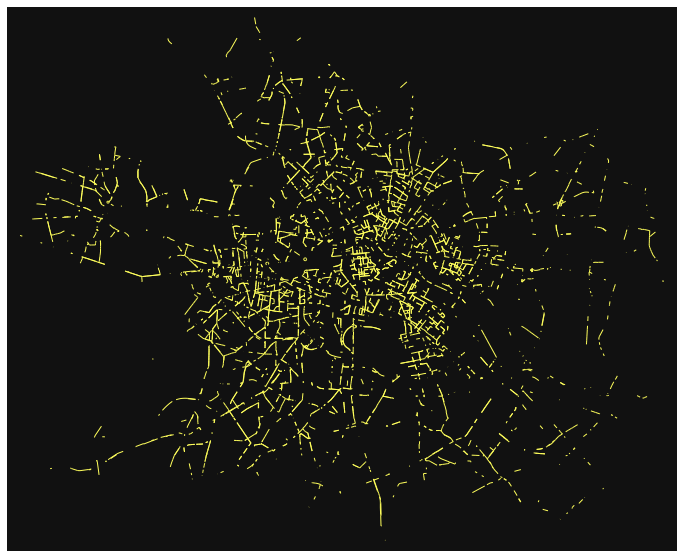

In [23]:
fig, ax = ox.plot_graph(final_g, figsize=(12, 12), node_color = 'r', node_size = 0, edge_linewidth = 1, edge_color = '#FFFF5C')

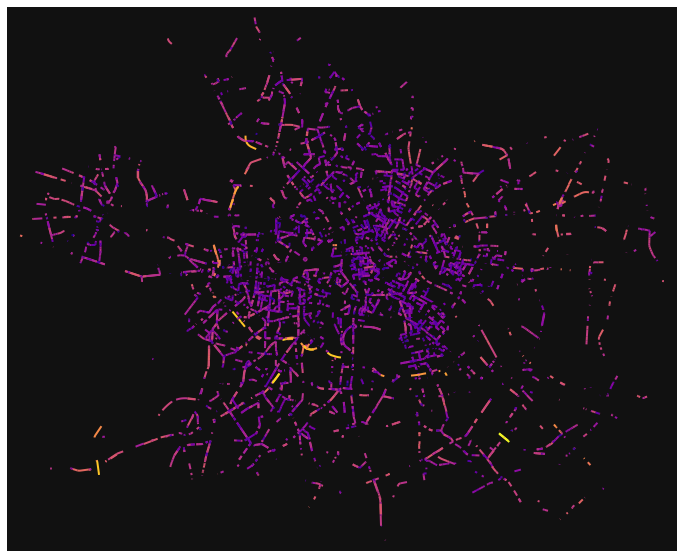

In [24]:
ec = ox.plot.get_edge_colors_by_attr(final_g, "speed_kph_mean", cmap="plasma")
fig, ax = ox.plot_graph(final_g, figsize=(12, 12), edge_color=ec, edge_linewidth=2, node_size=0, node_color = 'k')

### Network Analysis

In [25]:
print(type(final_g))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [26]:
nx.average_shortest_path_length(final_g)

NetworkXError: Graph is not weakly connected.

In [27]:
print(nx.classes.function.density(final_g))

1.1531522604484207e-05


In [28]:
nx.diameter(final_g)

NetworkXError: Found infinite path length because the digraph is not strongly connected

In [29]:
res_degree_centrality = nx.degree_centrality(final_g)
res_indegree = nx.in_degree_centrality(final_g)
res_outdegree = nx.out_degree_centrality(final_g)

In [77]:
df_in = pd.DataFrame()
df_in['node']  = res_indegree.keys()
df_in['value']  = res_indegree.values()
df_in = df_in.set_index('node')

df_in.head()

,value
node,
172546,0.000072
530313,0.000036
28345850,0.000072
172547,0.000036
34694265,0.000036


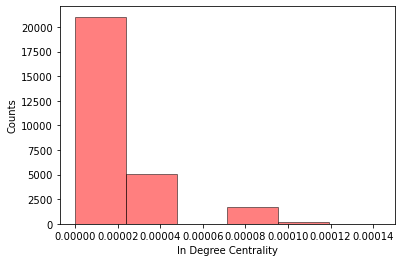

In [31]:
n, bins, patches = plt.hist(df_in['value'], 6, facecolor='r', alpha=0.5, edgecolor = 'k')

plt.xlabel('In Degree Centrality')
plt.ylabel('Counts')
plt.grid(False)
plt.show()

In [32]:
df_out = pd.DataFrame()
df_out['node']  = res_outdegree.keys()
df_out['value']  = res_outdegree.values()
df_out = df_out.set_index('node')

df_out.head()

,value
node,
172546,0.000072
530313,0.000036
28345850,0.000072
172547,0.000036
34694265,0.000036


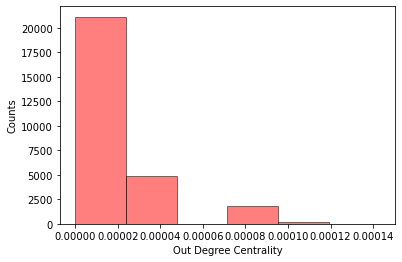

In [33]:
n, bins, patches = plt.hist(df_out['value'], 6, facecolor='r', alpha=0.5, edgecolor = 'k')

plt.xlabel('Out Degree Centrality')
plt.ylabel('Counts')
plt.grid(False)
plt.show()

### DiGraph Conversion

In [34]:
final_nodes.head()

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
172546,52.567738,13.352255,3,NaN,NaN,POINT (13.35225 52.56774)
530313,52.567835,13.352664,3,NaN,NaN,POINT (13.35266 52.56784)
28345850,52.567623,13.351325,4,NaN,NaN,POINT (13.35132 52.56762)
172547,52.564077,13.339564,3,NaN,NaN,POINT (13.33956 52.56408)
34694265,52.564277,13.338589,3,NaN,NaN,POINT (13.33859 52.56428)


In [78]:
final_edges.head()

osmid               name    highway maxspeed  \
u        v        key                                                    
172546   530313   0    24295532  Emmentaler Straße  secondary       50   
         28345850 0     4638312  Emmentaler Straße  secondary       50   
530313   172546   0    24295532  Emmentaler Straße  secondary       50   
28345850 35244866 0     4638312  Emmentaler Straße  secondary       50   
         29492967 0     4638317       Aroser Allee  secondary       50   

                       oneway   length  \
u        v        key                    
172546   530313   0     False   29.733   
         28345850 0      True   64.155   
530313   172546   0     False   29.733   
28345850 35244866 0      True   19.106   
         29492967 0      True  197.683   

                                                                geometry  \
u        v        key                                                      
172546   530313   0    LINESTRING (13.35225 52.56774, 13.35266 52.56784)   
         28345850 0    LINESTRING (13.35225 52.56774, 13.35207 52.567...   
530313   172546   0    LINESTRING (13.35266 52.56784, 13.35225 52.56774)   
28345850 35244866 0    LINESTRING (13.35132 52.56762, 13.35105 52.56758)   
         29492967 0    LINESTRING (13.35132 52.56762, 13.35129 52.567...   

                       hour_of_day  speed_kph_mean  speed_kph_stddev est_width  
u        v        key                                                           
172546   530313   0              9          45.276             6.040       NaN  
         28345850 0              9          14.532            14.245       NaN  
530313   172546   0              7          35.007            11.342       NaN  
28345850 35244866 0              8          35.756            11.516       NaN  
         29492967 0              8          46.770             5.457       NaN

In [80]:
print(type(final_g))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


In [81]:
berlin_digraph = nx.DiGraph(final_g)

Let's compare how much data we lost.

In [83]:
print(len(final_g.edges()))
print(len(berlin_digraph.edges()))

9012
9012


In [84]:
print(len(final_g.nodes()))
print(len(berlin_digraph.nodes()))

27956
27956


As you can see above, the lengths are equal. It's good that we haven't lost any data during the conversion to digraph.

In [88]:
pd.DataFrame.from_dict(berlin_digraph.nodes(), orient='index')

,y,x,street_count,ref,highway
172546,52.567738,13.352255,3,NaN,NaN
530313,52.567835,13.352664,3,NaN,NaN
28345850,52.567623,13.351325,4,NaN,NaN
172547,52.564077,13.339564,3,NaN,NaN
34694265,52.564277,13.338589,3,NaN,NaN
...,...,...,...,...,...
310509551,52.629525,13.298112,3,NaN,NaN
276037618,52.457755,13.150115,3,NaN,NaN
5104205814,52.402084,13.532213,1,NaN,NaN
276037624,52.455047,13.149873,3,NaN,NaN


In [89]:
pd.DataFrame.from_dict(berlin_digraph.edges(), orient='index')

osmid               name      highway maxspeed  \
172546     530313       24295532  Emmentaler Straße    secondary       50   
           28345850      4638312  Emmentaler Straße    secondary       50   
530313     172546       24295532  Emmentaler Straße    secondary       50   
28345850   35244866      4638312  Emmentaler Straße    secondary       50   
           29492967      4638317       Aroser Allee    secondary       50   
...                          ...                ...          ...      ...   
6206501300 6206500560    4615496     Berolinastraße  residential       30   
6366276983 29789747    385888165        Urbanstraße    secondary       50   
6400342990 6400342991  559214567      Wilhelmstraße     tertiary       50   
6469357849 700777138   334578487       Alt-Wittenau    secondary       50   
6556641548 59905492      4686368       Graefestraße  residential       50   

                       oneway   length  \
172546     530313       False   29.733   
           28345850      True   64.155   
530313     172546       False   29.733   
28345850   35244866      True   19.106   
           29492967      True  197.683   
...                       ...      ...   
6206501300 6206500560   False  121.381   
6366276983 29789747      True   33.976   
6400342990 6400342991   False   13.361   
6469357849 700777138     True   23.033   
6556641548 59905492     False   10.016   

                                                                geometry  \
172546     530313      LINESTRING (13.3522545 52.567738, 13.3526642 5...   
           28345850    LINESTRING (13.3522545 52.567738, 13.3520655 5...   
530313     172546      LINESTRING (13.3526642 52.5678354, 13.3522545 ...   
28345850   35244866    LINESTRING (13.351325 52.5676227, 13.35105 52....   
           29492967    LINESTRING (13.351325 52.5676227, 13.351286 52...   
...                                                                  ...   
6206501300 6206500560  LINESTRING (13.42452 52.5216592, 13.4244083 52...   
6366276983 29789747    LINESTRING (13.4192368 52.4900787, 13.4194129 ...   
6400342990 6400342991  LINESTRING (13.3804485 52.518071, 13.3804278 5...   
6469357849 700777138   LINESTRING (13.3217073 52.5935297, 13.3216125 ...   
6556641548 59905492    LINESTRING (13.4140923 52.4881481, 13.4141058 ...   

                       hour_of_day  speed_kph_mean  speed_kph_stddev est_width  
172546     530313                9          45.276             6.040       NaN  
           28345850              9          14.532            14.245       NaN  
530313     172546                7          35.007            11.342       NaN  
28345850   35244866              8          35.756            11.516       NaN  
           29492967              8          46.770             5.457       NaN  
...                            ...             ...               ...       ...  
6206501300 6206500560            8          26.346             5.005       NaN  
6366276983 29789747              8          40.362            13.430       NaN  
6400342990 6400342991            9          31.353            15.362       NaN  
6469357849 700777138             7          21.917            13.241       NaN  
6556641548 59905492              8          24.767            10.450       NaN  

[9012 rows x 11 columns]